<h2> Predict Loan Defaulters Part 3</h2>
This notebook will take as input the cleaned training/test data sets from the previous notebook (link below): <br>
Having the dataset pre-processed, we will now focus on model selection/building

<h3>Notebook Setup</h3>

<ol>
  <li>Create Transformers to handle diffrents processing needs of our dataset </li>
  <li>Apply Transformation to our Dataset</li>
  <li>Perform Prediction of Loan Defaulters</li>
  <li>Model Interpretation</li>
</ol> 

[Github Link to orginial notebooks and helper files](https://github.com/marcelkore/LendingClub_LoanDefaulters)

### Steps in the process
1. [Scaling Transformer](#scaling)
2. [Skew Transformer](#skew)
3. [Logistic Regression](#baseline_model)
4. [LightGBM_Model](#lgb_classifier)
5. [Feature Importance](#feature_importance)


In [5]:
# Standard Libraries
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer

# category encoding
import category_encoders as ce

#helper functions
import helper_functions as helpers
import modeling_helper_functions as mhf
import parameter_tuning_helper as pt
from skew_autotransform import skew_autotransform

# hyper-parameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from yellowbrick.classifier import ClassificationReport
from hyperopt.fmin import fmin

#sklearn libraries
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
import scikitplot as skplt
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from sklearn import metrics

# feature importance
import shap



# classification algorithms
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import itertools
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

import os
import warnings
from datetime import datetime
from datetime import date

# Viz Libraries
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
# scientific notation
pd.options.display.float_format = '{:.2f}'.format

### Data Dictionary
<h5> We will load the data dictionary to help us inspect each feature definition as we proceed </h5>

We will use data from 2017 and 2018. <br>

In [7]:
# training data#
train_set = pd.read_csv('lc_train_cleaned.csv')
test_set = pd.read_csv('lc_2018_test_cleaned.csv')
print('Train Set Shape: {}, Test Set Shape: {}'.format(train_set.shape,test_set.shape))

Train Set Shape: (385659, 7), Test Set Shape: (131526, 7)


In [8]:
# setting up this global variable to help toggle different settings during the train phase
CPU_COUNT = -1
CROSS_VAL_COUNT = 10
SCORING_METRIC = 'f1_weighted'
MAX_EVALUATIONS = 450

In [9]:
# we loose our categorical features during the export from previous notebook
# we carry these over and apply them to the dataset again
cat_features = ['term']

In [10]:
# %%script False
# we loose our categorical features during the export from previous notebook
train_set[cat_features] = train_set[cat_features].astype('category')
test_set[cat_features] = test_set[cat_features].astype('category')

In [11]:
# %%script False
train_set.iloc[:,0:25].select_dtypes(include='category').sample(2)
test_set.iloc[:,0:25].select_dtypes(include='category').sample(2)

,term
385542,36
62866,36


,term
50927,36.00
27526,36.00


<h2> <b> Scaling </b> </h2>
<a id="Scaling"></a>
<p>
Our data contains attributes with varying scales. As Brownlee (2019) points out, many learning algorithms can benefit from rescaling attributes to all have <br>
the same scale. This processing is useful for algorithms used in core machine learning that use gradient boosting or distance measures like k-nearest neighbors.
</p>
    
<p>
Another school of thought is that tree-based algorithms do not require scaling of the features. Having said that, we will still be scaling features in the event <br>
that we want to explore a Neural Network solution or any distance based algorithm. Furthermore, scaling features would not neccesarily degrade a tree-based algorithm <br>
    
Link below has a comparison of the different algorithms and which ones need scaling and which ones dont. 
</p>  
<p> <a href="https://www.dataschool.io/comparing-supervised-learning-algorithms/"> Comparing supervised learning algorithms </p>
    
    

<h3> Standardize Scaler </h3>

`Standardization` is a useful technique that transforms attributes with a non=gaussian distribution and different means and standard deviations to <br>
a standard Gaussian distribution with a mean of 0 and a standard deviation of 1. 

`Unsupervised learning algorithms`, in practice, more often benefit from standardization than from normalization; standardization is also preferred <br>
for a feature if the values this feature takes are distributed close to a normal distribution (so-called bell curve); again, standardization  <br>
is preferred for a feature if it can sometimes have extremely high or low values (outliers); this is because normalization will “squeeze” the normal <br>
values into a very small range; in all other cases, normalization is preferable.

In [12]:
class ScalingTransformer(TransformerMixin,BaseEstimator):
    """
    This transformer takes in a dataframe and performs
    standardization using the standard scaler library
    
    Input: Dataframe
    -----------------------------------
    Process: Using the data types, it will scale all available
    non-category features
    ------------------------------------
    Output: Dataframe with scaled numeric features
    """
       
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        scaler = StandardScaler()
        column_list = df.columns
        numeric_to_scale = df.select_dtypes(exclude='category').columns.tolist()
        category_to_scale = df.select_dtypes(include='category').columns.tolist()
        
        df[numeric_to_scale] = scaler.fit_transform(df[numeric_to_scale].to_numpy())
               
        return df

## Skew Transformer
<a id="skewed"></a>

In [13]:
class SkewTransformer(TransformerMixin,BaseEstimator):
    """
    This transformer uses a function that will accept a pandas dataframe
    and auto-transforms columns that exceeds threshold value
    
    #  -  Offers choice between boxcox or log / exponential transformation
    #  -  Automatically handles negative values
    # Source: https://datamadness.github.io/Skewness_Auto_Transform
    
    Input: Dataframe
    Output: dataframe with skewed features transformed
    """
       
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self

    def transform(self,df):
        
        exclude_columns = df.select_dtypes(include='category').columns.tolist()
        
        df = skew_autotransform(df.copy(deep=True), plot = False, 
                                   exp = True, threshold = 0.7, exclude = exclude_columns)
                     
        return df

### **Create Feature Matrix and Labels**

In [14]:
# drop our target feature
X_train = train_set.drop('loan_status', axis=1)
# save our target feature in a y variable
y_train = train_set.loan_status

# drop our target feature
X_test= test_set.drop('loan_status', axis=1)
# save our target feature in a y variable
y_test = test_set.loan_status

# review splits
print("X_train: {}, y_train: {}".format(X_train.shape,y_train.shape))

# review splits
print("X_test: {}, y_test: {}".format(X_test.shape,y_test.shape))

X_train: (385659, 6), y_train: (385659,)
X_test: (131526, 6), y_test: (131526,)


### **Store Category Feature Indexes**

In [15]:
# select cat features using dtypes
catft = [X_train.columns.get_loc(col) for col in cat_features]

In [16]:
catft

[5]

<h2> <b> Performance Metrics</b> </h2>
<a id="performance"></a>
We have an imbalanced dataset and the minority class are the loan defaulters (positive class represented by 0). One way to deal with imbalanced class <br>
proportions during model fitting is to assign a larger penalty to wrong predictions on the minority class. Via scikit-learn, adjusting such a penalty <br>
is as convenient as setting the class_weight parameter to class_weight='balanced', which is implemented for most classifiers. <br>

Other popular strategies for dealing with class imbalance include up-sampling the minority class, down-sampling the majority class, and the generation <br>
of synthetic training samples. Unfortunately, there's no universally best solution, no technique that works best across different problem domains. <br>
Thus, in practice, it is recommended to try out different strategies on a given problem, evaluate the results, and choose the technique that seems most appropriate.

Based on the class imbalance present in the dataset, we know that accuracy is not a good measure.To choose a suitable metric, we have to step back and look at the business problem <br>
we are trying to solve. This is a bank and the problem an imaginary VP has given us is to solve for loan defaulters. These are folks who take out loans and are <br>
not interested/ or are likely to default on the loan. The bank wants to minimize the likelihood of giving a loan to such people. We have more observations of people <br>
who `do not` default on their loan than people `who do`. <br>

Because of this fact, selecting all observations as `non defaulting` would lead to a higher accuracy which would be result in a useless model. <br>

KiwiDamien over at Stacked Turtles really helped me understand the different metrics. I'd recommend his blog as he explains concepts very clearly in my opinion. <br>
[Stacked Turtles](https://kiwidamien.github.io/).


We will focus on two metrics for this problem; Precision and Recall. <br>

`Precision:`  Out of all the positive cases identified, what fraction is actually positive<br>
We have to first define our positive case. In this instance, it is `non-defaulters`. If we assume 70% is our precision, it means that out of  all the loans approved <br>
(non-defaulters detected), 70% are actually non-defaulters while 30% of are defaulters. What this means is that the 30% of folks approved have the potential of costing Lending <br>
Club some money by defaulting on their loans.<br>
Precision = TP/TP+FP

`Recall:`  Out of all the positive cases identified, what fraction is actually positive i.e., what fraction are actually loan defaulters <br>
If we assume our model achieves a 70% recall, it means that 70% of `non-defaulters` are identified by the system for loan approval while the system would be <br>
rejecting 30% of `non-defaulters` who would pay back our loans and earn Lending Club interest. Think of these are missed opportunities for Lending Club to make money. <br>
Precision = TP/TP+FN

<br>
So for Lending Club, a decision has to be made as to which metric is important to them?  Is it important to ensure that defaulters are not <br>
issued loans (low precision) and thus cost them money at the end or is it important that we don't loose good business (low recall). 
<br>
<br>

They can also decide that they want to optimize for both. This can be achieved by using the `F1 Score` which is the harmonic mean between <br>
precision and recall. This metric will account for both the False Positives and False Negatives in the dataset and help the business achieve a happy medium. <br>

F1 Score = 2*(Recall * Precision) / (Recall + Precision) <br>

For our purpose, we will assume that the priority is getting a `f1 weighted` and so we will optimize for that.     

<h2> <b> Baseline Logistic Regression</b> </h2>
<a id="baseline_model"></a>

Lets create a baseline prediction that we can compare the results with. We will set our class weight to balanced since we know we have an imbalanced dataset <br>
Class weight set to balanced assigns a larger penalty on the minority class. There is no universal recommnded solution other than attempting different strategies for each problem

In [17]:
# Logistic Regression
logistic_r_model = LogisticRegression(class_weight='balanced',n_jobs=CPU_COUNT)

In [18]:
# parameter tuning
C = np.logspace(0, 4, 10)
solver = ['lbfgs','liblinear']
param_grid = {'C': C, 'solver' : solver}

lr_grid = GridSearchCV(estimator=logistic_r_model,
                       param_grid=param_grid,
                       cv=CROSS_VAL_COUNT,
                       n_jobs=CPU_COUNT,
                       scoring=SCORING_METRIC)

lr_grid = lr_grid.fit(X_train, y_train)
print('Best parameters : {}'.format(lr_grid.best_params_))

# Logistic Regression
logistic_r_model = LogisticRegression(class_weight='balanced',n_jobs=CPU_COUNT,
                                      C=lr_grid.best_params_['C'], solver=lr_grid.best_params_['solver'])

logistic_r_model

Best parameters : {'C': 21.544346900318832, 'solver': 'liblinear'}


LogisticRegression(C=21.544346900318832, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
# load preprocessing transformer
logistic_pipeline= Pipeline(steps=[
    ('scaling_transformer', ScalingTransformer()),
    ('skew_transformer', SkewTransformer()),
    ('logistic_regression', logistic_r_model)
])

In [20]:
# train lightgbm model
mhf.train_model(logistic_pipeline,
                X_train,y_train,
                scoring_metric=SCORING_METRIC,
                number_of_folds=CROSS_VAL_COUNT,
                n_jobs=CPU_COUNT)

Cross Validation f1_weighted Training Score for Pipeline is 65.458
Time elapsed (hh:mm:ss.ms) 0:00:04.286568


In [21]:
logistic_pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaling_transformer', ScalingTransformer()),
                ('skew_transformer', SkewTransformer()),
                ('logistic_regression',
                 LogisticRegression(C=21.544346900318832,
                                    class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='liblinear',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [22]:
# generate predictions
lr_ypred = logistic_pipeline.predict_proba(X_test)[:,1]

In [23]:
average_precision = average_precision_score(y_test, lr_ypred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.71


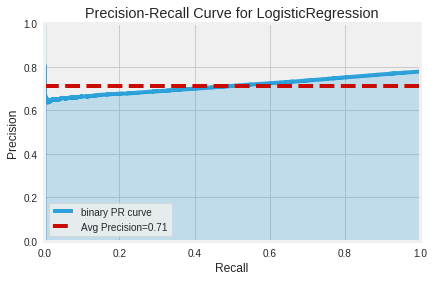

In [24]:
mhf.plot_precision_recall_curve_1(X_train,y_train, X_test,y_test, logistic_pipeline)

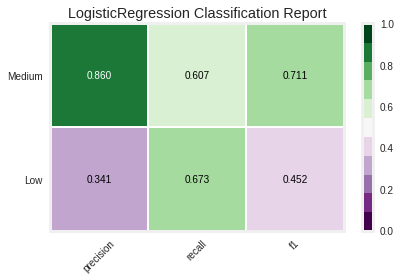

In [25]:
mhf.visual_model_selection(X_train,y_train, logistic_pipeline)

In [26]:
#mhf.plot_roc_auc_curve(lr_ypred,y_test,model=logistic_pipeline)

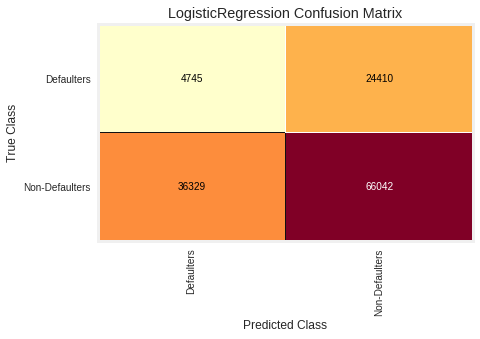

In [27]:
mhf.plot_confusion_matrix(X_train,y_train,
                          X_test, y_test,
                          model=logistic_pipeline,
                          encoder={0:'Defaulters', 1: 'Non-Defaulters'})

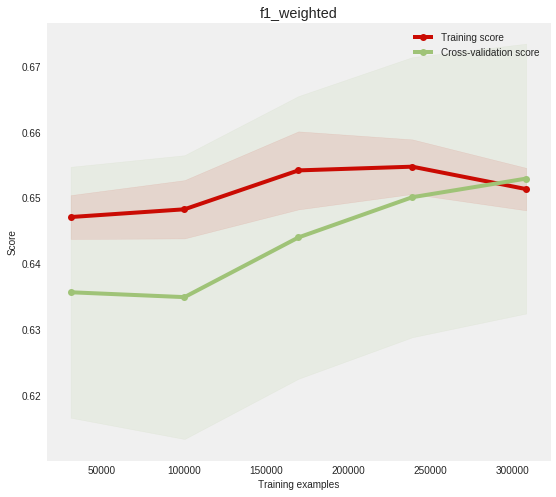

Time elapsed (hh:mm:ss.ms) 0:00:08.771040


In [28]:
# plot learning curve of the model
mhf.plot_learning_curve(logistic_pipeline,X_train,y_train,scoring=SCORING_METRIC,cpu_count=CPU_COUNT)

## **LightGBM**
<a id="lgb_classifier"></a>

### **Apply Light Gradient Boosting Model Classifier with Hyperopt Parameter Tuning**

LightGBM is a gradient boosting framework that uses a tree based learning algorithms with the following advantages <br><p>
* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.
    
   
>    LightGBM Documentation - https://lightgbm.readthedocs.io/en/latest/


<p> Several model tuning methods exist today with the most popular being gridsearch and randomsearch <br>
    I will be using HyperOpt library which uses bayesian framework that uses past trials to calculate the optimal <br> 
    parameters for a given model. The main difference between hyperopt and other methods is that the former methods <br>
    do not "learn" from each iteration on the data. <p>
        
>   More details here: https://hyperopt.github.io/hyperopt/

In [29]:
lgbm_optimized = pt.lgb_tuning(X_train, y_train,
                               X_test,y_test,
                               cpu_count=CPU_COUNT,
                               scoring=SCORING_METRIC,
                               cv_value=CROSS_VAL_COUNT,
                               max_evals_num=MAX_EVALUATIONS,
                               categorical_features=cat_features,
                               device_type='CPU')

100%|██████████| 450/450 [3:17:30<00:00, 26.33s/it, best loss: 0.15952009998417793]  


Time elapsed (hh:mm:ss.ms) 3:17:30.396944


In [30]:
lgbm_optimized

LGBMClassifier(boosting_type='gbdt', categorical_list=0,
               class_weight='balanced', colsample_bytree=0.8853346343801657,
               device_type='CPU', feature_fraction=0.5023332081627456,
               importance_type='split', learning_rate=0.238, max_depth=14,
               min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.05049104625216387, n_estimators=725, n_jobs=-1,
               num_leaves=113, objective='binary', random_state=None,
               reg_alpha=0.7701645833388854, reg_lambda=0.559754718786551,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [31]:
# load preprocessing transformers
lightgbm_pipeline= Pipeline(steps=[
    ('scaling_transformer', ScalingTransformer()),
    ('skew_transformer', SkewTransformer()),
    ('LightGBM', lgbm_optimized)
])

In [32]:
# train lightgbm model
mhf.train_model(lightgbm_pipeline,
                X_train,y_train,
                scoring_metric=SCORING_METRIC,
                number_of_folds=CROSS_VAL_COUNT,
                n_jobs=CPU_COUNT)

Cross Validation f1_weighted Training Score for Pipeline is 65.168
Time elapsed (hh:mm:ss.ms) 0:00:18.564515


In [33]:
lightgbm_pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaling_transformer', ScalingTransformer()),
                ('skew_transformer', SkewTransformer()),
                ('LightGBM',
                 LGBMClassifier(boosting_type='gbdt', categorical_list=0,
                                class_weight='balanced',
                                colsample_bytree=0.8853346343801657,
                                device_type='CPU',
                                feature_fraction=0.5023332081627456,
                                importance_type='split', learning_rate=0.238,
                                max_depth=14, min_child_samples=20,
                                min_child_weight=0.001,
                                min_split_gain=0.05049104625216387,
                                n_estimators=725, n_jobs=-1, num_leaves=113,
                                objective='binary', random_state=None,
                                reg_alpha=0.7701645833388854,
                             

In [34]:
# generate predictions
#lgb_ypred = lightgbm_pipeline.predict(X_test)
lgb_ypred = lightgbm_pipeline.predict_proba(X_test)[:,1]

In [35]:
average_precision = average_precision_score(y_test, lgb_ypred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.73


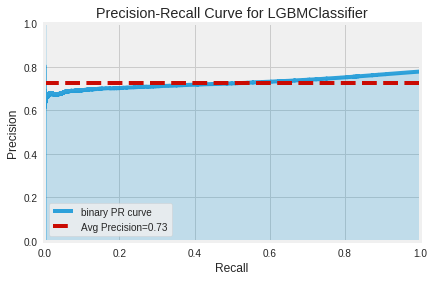

In [36]:
mhf.plot_precision_recall_curve_1(X_train,y_train, X_test,y_test, lightgbm_pipeline)

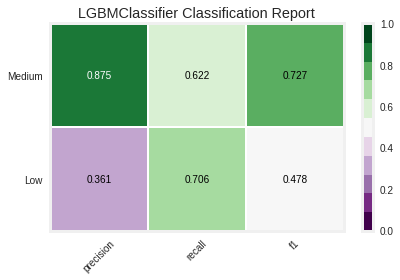

In [37]:
mhf.visual_model_selection(X_train,y_train, lightgbm_pipeline)

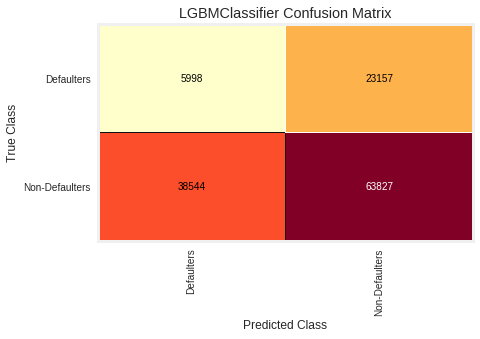

In [38]:
mhf.plot_confusion_matrix(X_train,y_train,
                          X_test, y_test,
                          model=lightgbm_pipeline,
                          encoder={0:'Defaulters', 1: 'Non-Defaulters'})

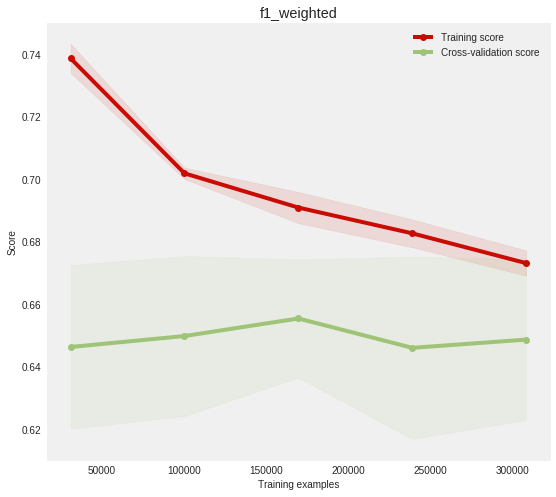

Time elapsed (hh:mm:ss.ms) 0:00:41.256248


In [39]:
# plot learning curve of the model
mhf.plot_learning_curve(lightgbm_pipeline,
                        X_train,y_train,
                        scoring=SCORING_METRIC,
                        cpu_count=CPU_COUNT)

### **Evaluate on hold-out 2019 Test Set**
<a id="holdouttest"></a>

In [40]:
test_set = pd.read_csv('lc_2019_test_cleaned.csv')

# we loose our categorical features during the export from previous notebook
test_set[cat_features] = test_set[cat_features].astype('category')

# review splits
print("X_train: {}, y_train: {}".format(X_train.shape,y_train.shape))


# split test set into features and target
X_test = test_set.drop('loan_status', axis=1)
y_test = test_set.loan_status

X_train: (385659, 6), y_train: (385659,)


In [41]:
# make a prediction using lightGBM classifier
lgb_ypred = lightgbm_pipeline.predict_proba(X_test)[:,1]

# make a prediction  using Logistic Regression
lr_ypred = logistic_pipeline.predict_proba(X_test)[:,1]

### Logistic Regression Score

In [42]:
average_precision = average_precision_score(y_test, lr_ypred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.82


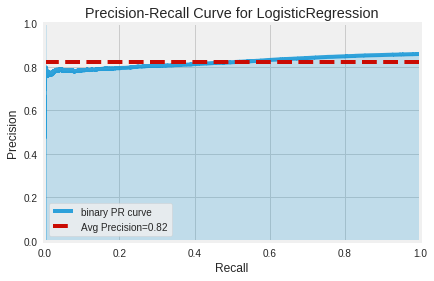

In [43]:
mhf.plot_precision_recall_curve_1(X_train,y_train, X_test,y_test, logistic_pipeline)

### LightGBM Score

In [44]:
average_precision = average_precision_score(y_test, lgb_ypred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.83


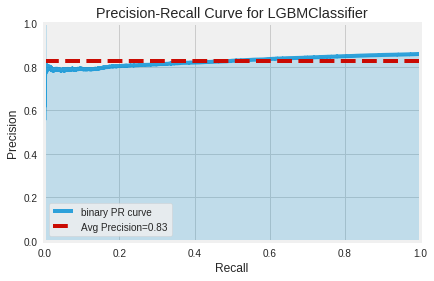

In [45]:
mhf.plot_precision_recall_curve_1(X_train,y_train, X_test,y_test, lightgbm_pipeline)

## **Feature Importance**

Feature Importance is particularly useful in highlighly regualted industries like banking. Society and powers that be need to <br>
know that you are not declining their loan application due to the color of their hair or something arbitary thats out of their control. <br>

This is partly the reason why I choose such a few # of features. I have seen papers where higher metrics are achieved but the models use <br>
all the features available. First of all, if the model were to make it in production, performance would be an issue. Secondly, 100 plus features <br>
becomes complicated when you need to explain  why a loan was declined. 

An additional topic is whether to perform feature importance on the test set or the training set. Christoph (2019) provides the pro's and cons which go <br>
something like this:
* Model error estimates based on training data are garbage. Measure some performance on the same data it was trained on provides far optimistic results. 
* We wouldn't test our model on training data. Thats why we have gone through the painstaking process of separating the two sets of data. <br> Why would we measure the 
importance on the training data also? 

### **Determining Feature Importance using Shap Values**
<a id="feature_importance"></a>

Given a set of predictors/features, Shap Values explain the prediction of each instance x by computing the contribution of each feature to the final prediction. <br>
If you think about the popular game show Jeopardy, ShapValues would help determine how a 'prize' would be distributed based on each persons contribution. <br>


We will use TreeExplainer for our LightGBM model as it specifically handles tree-based models.

In [46]:
shap.initjs()

In [47]:
explainer = shap.TreeExplainer(lgbm_optimized)
shap_values = explainer.shap_values(X_test)

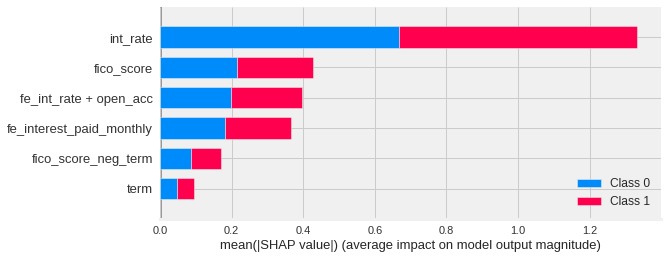

In [48]:
#plot summary feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [49]:
instance_to_explain = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][instance_to_explain], X_test.iloc[instance_to_explain])

A note about the feature selection - I also used RFECV and while it achieved a higher score, it also required 26 features in the model as opposed to only 7 for this model. I opted with to use the features<br>
selected by the WOE method as they were smaller and allowed faster processing.

### References

<p> Beyeler, M. (2017) 'Machine Learning for OpenCV' Packt Publishing 2017 </p>
<p> Brownlee, J. (2019) 'Machine Learning Mastery with Python' 
<p> Boschetti A and Massaron L (2018). 'Python Data Science Essentials: 3rd Edition' Packt Publishing  </p>
<p> Burkov, A. (2019). 'The Hundred-Page Machine Learning Book' Publisher: Andriy Burkov </p>
<p> Christoph,M (2019) 'Interpretable Machine Learning' Available at: https://christophm.github.io/interpretable-ml-book/shap.html (Accessed: December 13th, 2019)
<p> Stefan, J. (2018) 'Hands-On Machine Learning for Algorithmic Trading'. Packt Publishing 2018 </p>
<p> Zheng A & Casari A. (2018). 'Feature Engineering for Machine Learning' Sebastopol, CA: O'Reilly Publishing </p>